### Описание:
NER - это задача выделения и классификации именованных сущностей в тексте, таких как имена, организации, места, даты и другие.

### Значимость задачи:

Информационный поиск: Эффективное выделение сущностей облегчает поиск и извлечение информации из текстов.

Обработка текстов: Для многих задач обработки естественного языка, таких как машинный перевод, суммаризация и кластеризация, важно точно распознавать именованные сущности.

### Проблемы, которые решает:

Информационный шум: Выделение именованных сущностей помогает снизить информационный шум в текстах, делая их более структурированными и понятными.

Повышение эффективности поиска: При поиске по большим корпусам текстов NER улучшает точность и релевантность результатов.

Разведывательный анализ: В разведывательном анализе данных NER может использоваться для выделения ключевых сущностей, помогая понимать ключевые темы и актеров в текстах.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from transformers import BertTokenizer, TFBertForTokenClassification, TFTrainer, TFTrainingArguments
from tqdm import tqdm

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU доступен. Используется", physical_devices[0])
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU не доступен. Используется CPU.")

GPU не доступен. Используется CPU.


In [3]:
file_path = "lenta-ru-news.csv"
data = pd.read_csv(file_path)

print("Общая информация о датасете:")
print(data.info())

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739351 entries, 0 to 739350
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     739351 non-null  object
 1   title   739351 non-null  object
 2   text    739346 non-null  object
 3   topic   739148 non-null  object
 4   tags    712837 non-null  object
dtypes: object(5)
memory usage: 28.2+ MB
None


C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


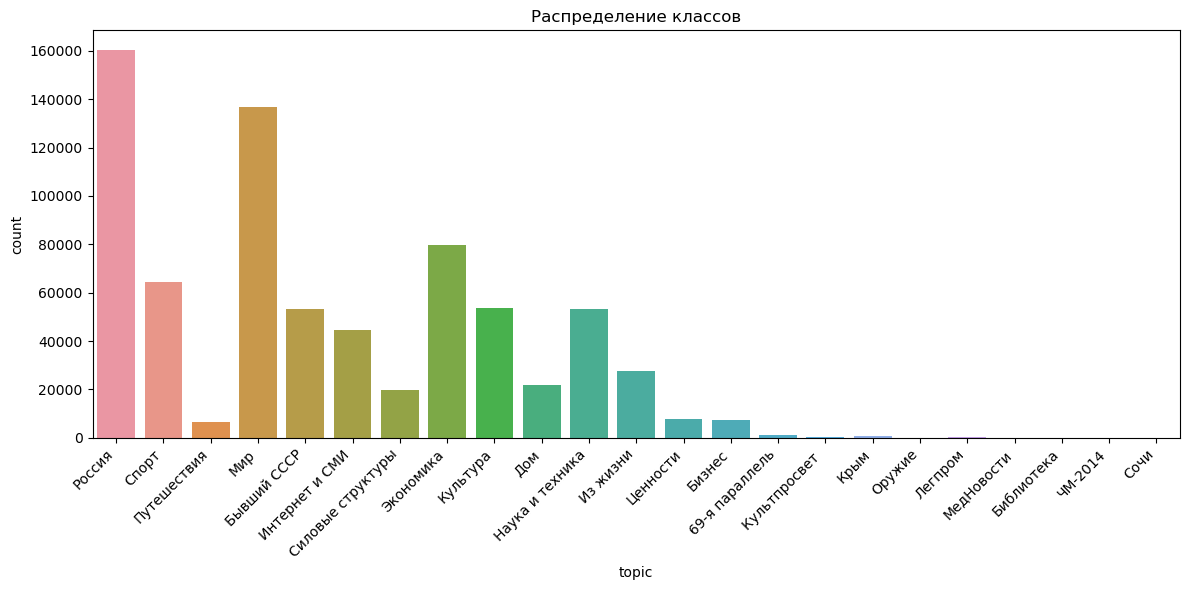

In [4]:
# Распределение классов
plt.figure(figsize=(12, 6))
sns.countplot(x='topic', data=data)
plt.title('Распределение классов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Дисбаланс классов
class_distribution = data['topic'].value_counts()
print("Распределение классов:")
print(class_distribution)

Распределение классов:
topic
Россия               160519
Мир                  136680
Экономика             79538
Спорт                 64421
Культура              53803
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44675
Из жизни              27611
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: count, dtype: int64


C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


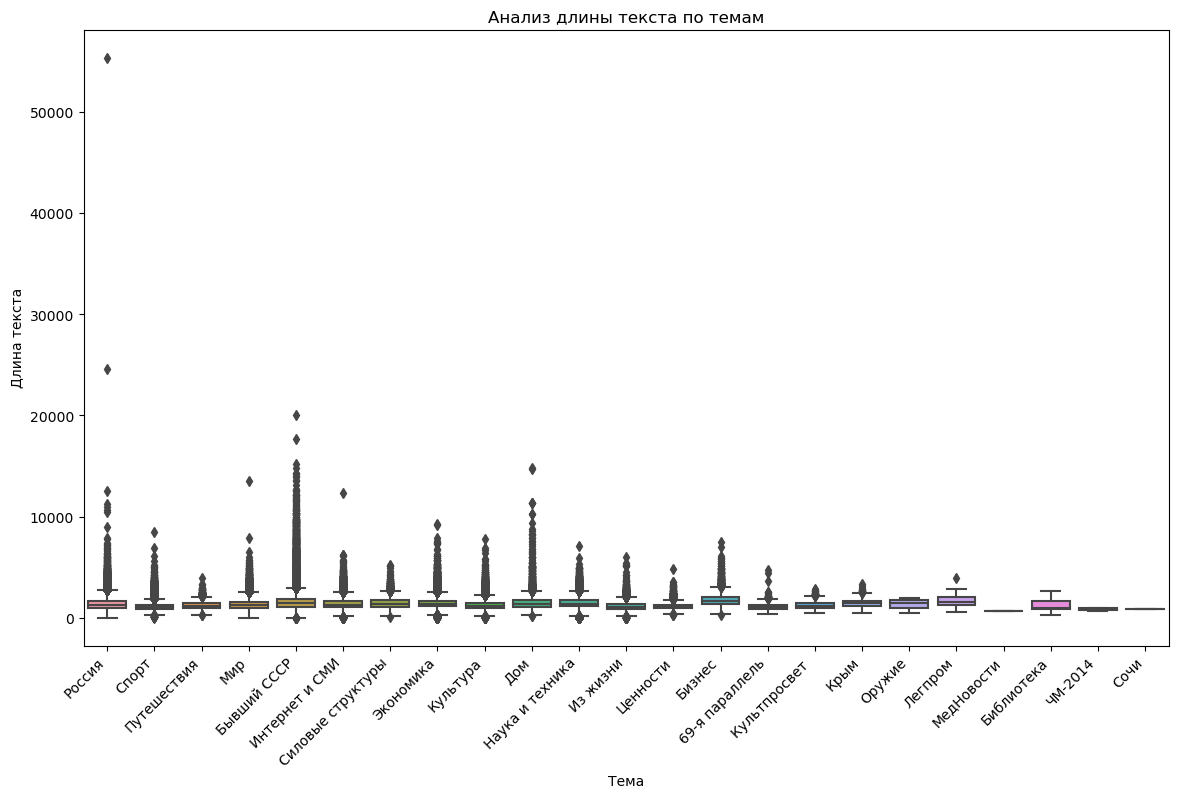

In [6]:
# Удалим возможные пропуски в данных
data.dropna(subset=['text', 'topic'], inplace=True)

# Создадим новый датасет только с нужными колонками
data_for_analysis = data[['text', 'topic']]

# Анализ длины текстов в зависимости от темы (topic)
plt.figure(figsize=(14, 8))
sns.boxplot(x='topic', y=data_for_analysis['text'].apply(len), data=data_for_analysis)
plt.title('Анализ длины текста по темам')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Тема')
plt.ylabel('Длина текста')
plt.show()

In [7]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data_for_analysis['text'], data_for_analysis['topic'], test_size=0.2, random_state=42)

# Выведем размеры полученных выборок
print(f"Размер обучающей выборки: {len(X_train)} текстов")
print(f"Размер тестовой выборки: {len(X_test)} текстов")

Размер обучающей выборки: 591314 текстов
Размер тестовой выборки: 147829 текстов


In [8]:
# Инициализация токенизатора
tokenizer = Tokenizer()

# Обучение токенизатора на обучающих данных
tokenizer.fit_on_texts(X_train)

# Преобразование текстов в числовые последовательности
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Задаем максимальную длину последовательности (можно выбрать экспериментально)
max_sequence_length = 100

# Постобработка: дополнение последовательностей до максимальной длины
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

# Инициализация кодировщика меток
label_encoder = LabelEncoder()

# Обучение кодировщика на обучающих метках
label_encoder.fit(y_train)

# Преобразование текстовых меток в числовой формат
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

C:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\anaconda3\Lib\site-packages\s

In [9]:
path_to_glove_file = 'glove.42B.300d.txt'
embedding_dim = 300
word_index = tokenizer.word_index
embeddings_index = {}
with open(path_to_glove_file, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Создание модели
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))
model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=len(set(y_train)), activation='softmax'))

# Компиляция модели
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5


14783/14783 [==============================] - 3744s 253ms/step - loss: 1.9681 - accuracy: 0.3631 - val_loss: 1.8147 - val_accuracy: 0.4242
Epoch 2/5
14783/14783 [==============================] - 3291s 223ms/step - loss: 1.7716 - accuracy: 0.4346 - val_loss: 1.7163 - val_accuracy: 0.4508
Epoch 3/5
14783/14783 [==============================] - 3324s 225ms/step - loss: 1.7102 - accuracy: 0.4510 - val_loss: 1.6775 - val_accuracy: 0.4624
Epoch 4/5
14783/14783 [==============================] - 3344s 226ms/step - loss: 1.6700 - accuracy: 0.4626 - val_loss: 1.6499 - val_accuracy: 0.4699
Epoch 5/5
14783/14783 [==============================] - 3342s 226ms/step - loss: 1.6438 - accuracy: 0.4694 - val_loss: 1.6310 - val_accuracy: 0.4741


In [10]:
# Оценка модели
evaluation_results = model.evaluate(X_test_padded, y_test_encoded)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

4620/4620 [==============================] - 235s 51ms/step - loss: 1.6224 - accuracy: 0.4760
Test Loss: 1.6223647594451904
Test Accuracy: 0.47602295875549316


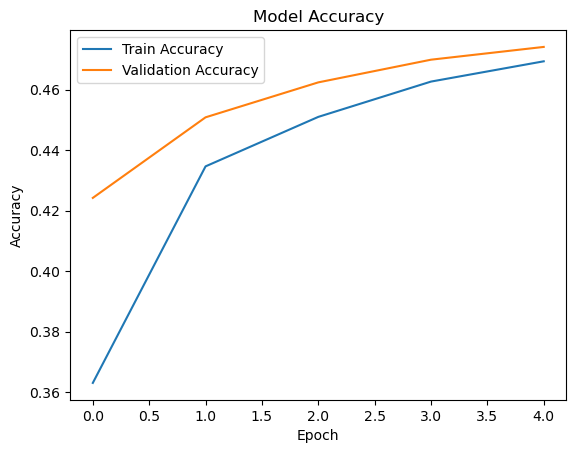

In [11]:
# Визуализация результатов обучения
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Выводы и результаты
